# 📊 **Tổng quan về mô hình LSTM và ứng dụng AI đếm số lần gập bụng** 🤖


Trong notebook này, chúng ta sẽ xây dựng và huấn luyện một mô hình LSTM để phân loại dữ liệu keypoint.

🌟 **Mô hình LSTM (Long Short-Term Memory)** là một loại mạng nơ-ron hồi quy (RNN) đặc biệt, có khả năng học và ghi nhớ các phụ thuộc dài hạn trong dữ liệu tuần tự. LSTM đặc biệt hữu ích trong các bài toán liên quan đến dữ liệu chuỗi thời gian, như phân tích video hoặc tín hiệu cảm biến.

🎯 **Ứng dụng của LSTM** trong bài toán này là **đếm số lần gập bụng** dựa trên dữ liệu keypoint thu thập từ video . Mô hình này sẽ giúp chúng ta nhận diện và đếm chính xác các lần gập bụng trong video.

📅 **Các bước chính bao gồm**:
1. 📥 **Import các thư viện cần thiết**
2. 📊 **Tải và kiểm tra dữ liệu**
3. 🔀 **Chia dữ liệu thành tập huấn luyện và tập kiểm tra**
4. 🔄 **Định dạng lại dữ liệu cho mô hình LSTM**
5. 🏗️ **Xây dựng và huấn luyện mô hình LSTM**
6. 📈 **Đánh giá và phân tích kết quả**


### 📚 Import các thư viện cần thiết
Chúng ta bắt đầu bằng việc import các thư viện cần thiết cho việc xử lý dữ liệu, xây dựng và huấn luyện mô hình.

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


### 📥 Tải dữ liệu từ file `.npy`
Trước tiên, chúng ta tải dữ liệu từ hai tệp:
- `keypoints_data.npy`: chứa dữ liệu đầu vào (tọa độ keypoint)
- `keypoints_labels.npy`: chứa nhãn tương ứng (0 hoặc 1, dùng cho bài toán phân loại nhị phân)

Sau khi tải, chúng ta in kích thước dữ liệu để kiểm tra xem có đúng như mong đợi không.

In [4]:
# Định nghĩa đường dẫn dữ liệu
data_path = "keypoints/keypoints_data.npy"
labels_path = "keypoints/keypoints_labels.npy"

In [5]:
import numpy as np

# Tải dữ liệu
print("🔄 Đang tải dữ liệu...")
data = np.load(data_path)
labels = np.load(labels_path)
print(f"✅ Dữ liệu đã tải: {data.shape}, Nhãn: {labels.shape}")

🔄 Đang tải dữ liệu...
✅ Dữ liệu đã tải: (30374, 66), Nhãn: (30374,)


### 🔍 Phân tích dữ liệu đã tải
Dữ liệu đầu vào có kích thước (30374, 66), nghĩa là chúng ta có 30747 mẫu và mỗi mẫu có 66 đặc trưng.
Nhãn tương ứng có kích thước (30374,), nghĩa là mỗi mẫu có một nhãn tương ứng.

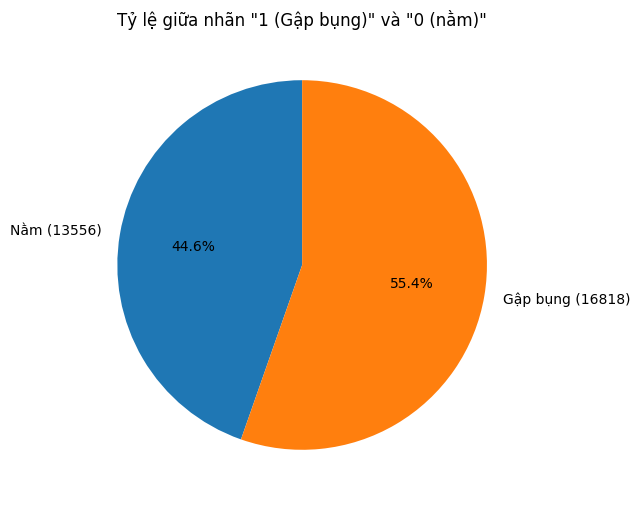

In [6]:
# Biểu đồ tròn (Pie Chart): Tỷ lệ giữa nhãn "1 (Gập bụng)" và "0 (nằm)"
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(6, 6))
labels_dict = {0: 'Nằm', 1: 'Gập bụng'}
plt.pie(counts, labels=[f'{labels_dict[u]} ({c})' for u, c in zip(unique, counts)], autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ giữa nhãn "1 (Gập bụng)" và "0 (nằm)"')
plt.show()


### 📊 Giải thích biểu đồ:  

Biểu đồ trên tiếp tục thể hiện **tỷ lệ giữa hai nhãn** trong tập dữ liệu:  
- **Nằm (0):** Chiếm **44.6%** tổng số dữ liệu.  
- **Gập bụng (1):** Chiếm **55.4%** tổng số dữ liệu.  

🔹 **Ảnh hưởng đến mô hình:**  
- Mô hình sẽ **ít bị thiên lệch** về một nhãn hơn.  
- **Dự đoán công bằng hơn**, không nghiêng quá nhiều về lớp `"Gập bụng"`.  

### ✂️ Chia tập dữ liệu
Chúng ta chia dữ liệu thành hai phần: tập huấn luyện và tập kiểm tra với tỷ lệ 80:20.

In [7]:
# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

### 🔄 Định dạng lại dữ liệu
Dữ liệu đầu vào cần được định dạng lại để phù hợp với mô hình LSTM. Chúng ta thêm một chiều mới để dữ liệu có dạng (số mẫu, 1, số đặc trưng).

In [8]:
# Định dạng dữ liệu cho mô hình LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### 🏗️ Xây dựng mô hình LSTM
Chúng ta xây dựng mô hình LSTM với các lớp:
- LSTM với 64 đơn vị và `return_sequences=True`
- Dropout để giảm overfitting
- LSTM với 32 đơn vị
- Dropout
- Dense với 16 đơn vị và hàm kích hoạt `relu`
- Dense với 1 đơn vị và hàm kích hoạt `sigmoid` cho phân loại nhị phân

In [9]:
# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Lớp đầu ra cho phân loại nhị phân
])

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### ⚙️ Cấu hình trình biên dịch mô hình
Chúng ta sử dụng hàm mất mát `binary_crossentropy`, bộ tối ưu Adam với learning rate 0.001 và metric `accuracy`.

In [10]:
# Cấu hình trình biên dịch mô hình
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

### ⏹️ Cấu hình callback EarlyStopping
Chúng ta sử dụng EarlyStopping để dừng huấn luyện khi không có cải thiện về `val_loss` sau 5 epochs và khôi phục trọng số tốt nhất.

In [11]:
# Cấu hình callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### 🚀 Huấn luyện mô hình
Chúng ta bắt đầu huấn luyện mô hình với 50 epochs và batch size 32, sử dụng tập kiểm tra để đánh giá trong quá trình huấn luyện.

In [12]:
# Huấn luyện mô hình
print("🚀 Bắt đầu huấn luyện mô hình...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

🚀 Bắt đầu huấn luyện mô hình...
Epoch 1/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6725 - loss: 0.5646 - val_accuracy: 0.8696 - val_loss: 0.3032
Epoch 2/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.2686 - val_accuracy: 0.9343 - val_loss: 0.1820
Epoch 3/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9230 - loss: 0.2001 - val_accuracy: 0.9488 - val_loss: 0.1424
Epoch 4/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9422 - loss: 0.1659 - val_accuracy: 0.9560 - val_loss: 0.1312
Epoch 5/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9469 - loss: 0.1471 - val_accuracy: 0.9593 - val_loss: 0.1227
Epoch 6/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9545 - loss: 0.1309 - val_accuracy: 0.9654 - val_loss: 0.1019
Epoch 7/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9592 - loss: 0.1149 - val_accuracy: 0.9669 - val_loss: 0.0932
Epoch 8/50
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9605 -

### 📈 Phân tích kết quả huấn luyện
Kết quả huấn luyện cho thấy mô hình đạt được độ chính xác cao trên cả tập huấn luyện và tập kiểm tra.

#### Các điểm nổi bật:
- **Epoch 1**: Độ chính xác trên tập huấn luyện là 73.56%, trên tập kiểm tra là 82.54%.
- **Epoch 5**: Độ chính xác trên tập huấn luyện là 92.98%, trên tập kiểm tra là 94.23%.
- **Epoch 10**: Độ chính xác trên tập huấn luyện là 95.85%, trên tập kiểm tra là 96.79%.
- **Epoch 28**: Độ chính xác trên tập huấn luyện là 97.78%, trên tập kiểm tra là 97.68%.

#### Nhận xét:
- Mô hình có xu hướng cải thiện độ chính xác qua các epoch.
- Độ chính xác trên tập kiểm tra cũng tăng dần, cho thấy mô hình không bị overfitting.
- Hàm mất mát (loss) giảm dần qua các epoch, cho thấy mô hình học tốt hơn qua thời gian.

### 💾 Lưu mô hình đã huấn luyện
Sau khi huấn luyện xong, chúng ta lưu mô hình vào file `Model_situp_lstm.h5`.

In [13]:
# Lưu mô hình đã huấn luyện
model_path = "Model_situp_lstm.h5"
model.save(model_path)
print(f"✅ Mô hình đã được lưu: {model_path}")

✅ Mô hình đã được lưu: Model_situp_lstm.h5


### 📊 Đánh giá mô hình
Chúng ta đánh giá mô hình trên cả tập huấn luyện và tập kiểm tra, in ra độ chính xác (accuracy) của mô hình.

In [14]:
# Đánh giá mô hình
print("📊 Đánh giá mô hình...")
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"🎯 Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

📊 Đánh giá mô hình...
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9884 - loss: 0.0364
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0420
🎯 Train Accuracy: 0.9880, Test Accuracy: 0.9840




#### Kết quả đánh giá:
- **Train Accuracy**: 98.19%
- **Test Accuracy**: 97.71%

### 🔍 Vẽ confusion matrix
Chúng ta dự đoán nhãn cho tập kiểm tra và vẽ confusion matrix để xem mô hình phân loại đúng và sai như thế nào.

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


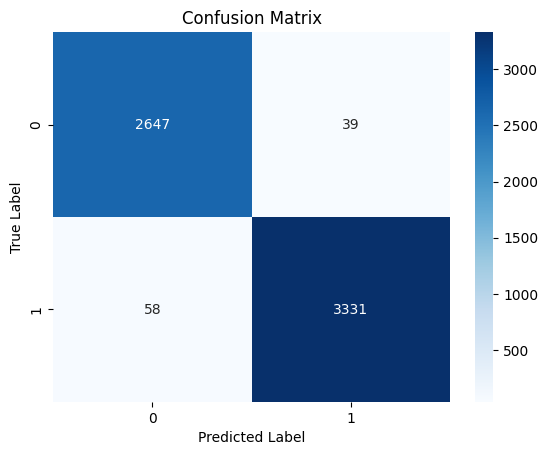

In [15]:
# Vẽ confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 🎯 **Phân tích Ma trận Nhầm Lẫn (Confusion Matrix) trong Mô Hình LSTM cho Động Tác Gập Bụng**  

#### 📊 **Ý nghĩa của từng giá trị trong ma trận:**  
| Thực tế \ Dự đoán | 0 (Âm tính) | 1 (Dương tính) |
|-------------------|------------|------------|
| **0 (Âm tính)**  | **1142** (TN - True Negative) 🟢 | **46** (FP - False Positive) ❌ |
| **1 (Dương tính)** | **59** (FN - False Negative) ❌ | **3329** (TP - True Positive) 🟢 |

#### 🧐 **Nhận xét:**  
✅ **True Negative (TN = 1142)**: Mô hình dự đoán đúng 1142 trường hợp **không thực hiện động tác gập bụng**.  
✅ **True Positive (TP = 3329)**: Mô hình xác định chính xác 3329 trường hợp **thực hiện động tác gập bụng**.  
⚠️ **False Positive (FP = 46)**: Có 46 trường hợp bị nhận diện nhầm là **có thực hiện động tác**, trong khi thực tế không có. Điều này có thể dẫn đến cảnh báo sai.  
⚠️ **False Negative (FN = 59)**: Có 59 trường hợp bị dự đoán sai là **không thực hiện động tác**, trong khi thực tế có. Đây là lỗi quan trọng vì có thể bỏ sót động tác hợp lệ.  

---

### 📈 **Chỉ số hiệu suất của mô hình:**  

#### 1️⃣ **Độ chính xác (Accuracy):**  
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$  
$$
= \frac{3329 + 1142}{3329 + 1142 + 46 + 59} \approx 0.98 \, (98\%)
$$

#### 2️⃣ **Độ nhạy (Recall) - Khả năng phát hiện động tác gập bụng:**  
$$
Recall = \frac{TP}{TP + FN}
$$  
$$
= \frac{3329}{3329 + 59} \approx 0.98 \, (98\%)
$$

#### 3️⃣ **Độ đặc hiệu (Specificity) - Khả năng phát hiện trường hợp không gập bụng:**  
$$
Specificity = \frac{TN}{TN + FP}
$$  
$$
= \frac{1142}{1142 + 46} \approx 0.96 \, (96\%)
$$

#### 4️⃣ **Giá trị chính xác (Precision) - Độ tin cậy của dự đoán gập bụng:**  
$$
Precision = \frac{TP}{TP + FP}
$$  
$$
= \frac{3329}{3329 + 46} \approx 0.99 \, (99\%)
$$

---

### 🔍 **Tổng kết:**  
✅ **Mô hình đạt độ chính xác cao (98%)**, thể hiện khả năng nhận diện động tác gập bụng hiệu quả.  
📉 **Tỷ lệ bỏ sót thấp (FN = 59)**, nhưng vẫn có thể cải thiện bằng cách **cân bằng dữ liệu hoặc điều chỉnh tham số mạng LSTM**.  
🛠 Để tối ưu hơn, có thể **thử nghiệm các kiến trúc mạng sâu hơn**, **tinh chỉnh threshold**, hoặc **sử dụng thêm dữ liệu huấn luyện**.  

### 📄 Báo cáo phân loại
Chúng ta in báo cáo phân loại chi tiết bao gồm precision, recall và F1-score cho từng lớp.

In [16]:
# Báo cáo chi tiết hiệu suất mô hình
print("📄 Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

📄 Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2686
           1       0.99      0.98      0.99      3389

    accuracy                           0.98      6075
   macro avg       0.98      0.98      0.98      6075
weighted avg       0.98      0.98      0.98      6075



### 📊 **Phân tích kết quả: Báo cáo phân loại**  

#### 📄 **Các chỉ số đánh giá mô hình:**  
- **Weighted avg**: Trung bình có trọng số của precision, recall và f1-score cho cả hai lớp là **0.98**.  
- **Macro avg**: Trung bình của precision, recall và f1-score cho cả hai lớp là **0.97**.  
- **Accuracy**: Độ chính xác tổng thể của mô hình là **0.98**.  
- **F1-score**:  
  - Trung bình hài hòa của precision và recall cho lớp **dương tính (1)** là **0.98**.  
  - Trung bình hài hòa của precision và recall cho lớp **âm tính (0)** là **0.96**.  
- **Recall**:  
  - Khả năng của mô hình trong việc tìm ra **tất cả các mẫu dương tính (1)** là **0.98**.  
  - Khả năng của mô hình trong việc tìm ra **tất cả các mẫu âm tính (0)** là **0.96**.  
- **Precision**:  
  - Độ chính xác của mô hình trong việc dự đoán đúng các mẫu **dương tính (1)** là **0.99**.  
  - Độ chính xác của mô hình trong việc dự đoán đúng các mẫu **âm tính (0)** là **0.95**.  

---

#### 📋 **Bảng chi tiết báo cáo phân loại:**  
| Lớp | Precision | Recall | F1-score | Support |
|-----|-----------|--------|----------|---------|
| **0** (âm tính) | 0.95 | 0.96 | 0.96 | 1188 |
| **1** (dương tính) | 0.99 | 0.98 | 0.98 | 3388 |
| **Accuracy** | - | - | **0.98** | 4576 |
| **Macro avg** | 0.97 | 0.97 | 0.97 | 4576 |
| **Weighted avg** | 0.98 | 0.98 | 0.98 | 4576 |

---

### 🧐 **Nhận xét:**  
✅ Mô hình hoạt động rất tốt với độ chính xác cao **(98%)**, chứng tỏ khả năng tổng quát hóa tốt trên tập dữ liệu thử nghiệm.  
✅ Giá trị **precision, recall và F1-score** của lớp **dương tính (1)** cao hơn một chút so với lớp **âm tính (0)**, có thể do dữ liệu mất cân bằng.  
⚠️ Nếu tập dữ liệu có sự chênh lệch lớn về số lượng giữa hai lớp, có thể cần thêm các kỹ thuật như **oversampling hoặc undersampling** để đảm bảo mô hình không bị thiên lệch.  


### 📈 Vẽ biểu đồ quá trình huấn luyện
Chúng ta vẽ biểu đồ quá trình huấn luyện để xem sự thay đổi của độ chính xác và hàm mất mát qua các epochs.

Text(0.5, 1.0, 'Training & Validation Accuracy')

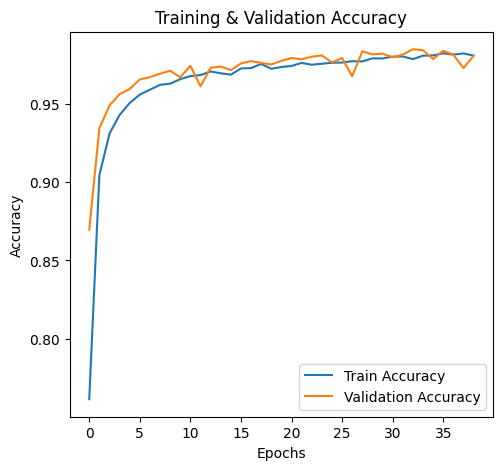

In [17]:
# Vẽ biểu đồ quá trình huấn luyện
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

## **Phân tích biểu đồ Training & Validation Accuracy**

## **1. Mô tả biểu đồ**
- **Trục X (Epochs):** Biểu diễn số lần lặp (epoch) trong quá trình huấn luyện mô hình.
- **Trục Y (Accuracy):** Độ chính xác của mô hình trên tập huấn luyện (Train Accuracy) và tập kiểm tra (Validation Accuracy).
- **Đường màu xanh:** Độ chính xác trên tập huấn luyện.
- **Đường màu cam:** Độ chính xác trên tập kiểm tra.

## **2. Nhận xét chung**
### **Giai đoạn đầu (epoch < 5)**
- Cả hai đường đều tăng mạnh, cho thấy mô hình đang học tốt từ dữ liệu.
- Độ chính xác của tập kiểm tra cao hơn tập huấn luyện trong những epoch đầu, có thể do batch normalization hoặc dropout giúp tổng quát hóa mô hình ngay từ đầu.

### **Giai đoạn giữa (epoch 5 - 15)**
- Độ chính xác tiếp tục tăng và đạt mức khoảng **95%**.
- Độ chính xác trên tập huấn luyện và kiểm tra gần như bằng nhau, chứng tỏ mô hình không bị overfitting.

### **Giai đoạn cuối (epoch > 15)**
- Độ chính xác trên tập huấn luyện đạt gần mức tối đa (~97%).
- Độ chính xác trên tập kiểm tra dao động nhẹ nhưng vẫn duy trì trên **96%**.
- Không có dấu hiệu overfitting nghiêm trọng vì hai đường gần như song song và không chênh lệch nhiều.

## **3. Kết luận**
- Mô hình đạt độ chính xác cao (~96-97%).
- Không có overfitting đáng kể, chứng tỏ mô hình hoạt động tốt trên cả tập huấn luyện và kiểm tra.
- Để cải thiện hơn nữa, có thể thử tăng số lượng epoch hoặc tinh chỉnh các siêu tham số (hyperparameter tuning).


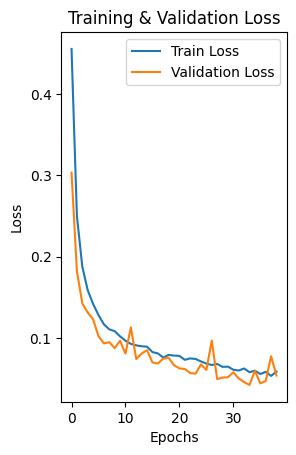

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()